<a href="https://colab.research.google.com/github/kostenk0/Etalony/blob/master/Etalony.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import math

x1s = 1.0
x1f = 5.0
x2s = 1.0
x2f = 4.0
k1 = 3
k2 = 2
l = 1000

x1 = np.arange(x1s, x1f+0.00001, (x1f-x1s)/(k1+1))
x2 = np.arange(x2s, x2f+0.00001, (x2f-x2s)/(k2+1))

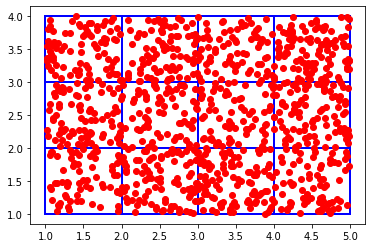

In [0]:
def plotClasses():
  for i in x1:
    plt.plot([i,i], [x2s,x2f], "b-", linewidth=2.0)
  for i in x2:
    plt.plot([x1s,x1f], [i,i], "b-", linewidth=2.0)

def getDataset():
  res = np.zeros((l, 2))
  for i in range(l):
    res[i][0] = x1s + (x1f-x1s)*rnd.random()
    res[i][1] = x2s + (x2f-x2s)*rnd.random()
  return res

plotClasses()
X = getDataset()
plt.plot(X[:,0], X[:,1], "ro")
plt.show()

In [0]:
# creating Y, where Y[i] = class of ith element in X
def getClass(x, y):
  res1 = res2 = 0
  for i in x1[:-1]:
    if x >= i:
      res1 += 1
  for i in x2[:-1]:
    if y >= i:
      res2 += 1
  return (res1, res2)

Y = []
for i in range(l):
  Y.append(getClass(X[i][0], X[i][1]))

# sorted set of all existing classes
allClasses = sorted(set(Y))

# dictionary of all indices of points from X that are from class
classPoints = {}
for cl in allClasses:
  classPoints[cl] = []
for i in range(l):
  classPoints[Y[i]].append(i)

In [0]:
# measuring all distances between points
def distanceBetween(fr, to):
  return math.sqrt((fr[0] - to[0])**2 + (fr[1] - to[1])**2)

def getAllDistances(X):
  length = X[:,0].size
  distances = np.zeros((length, length-1))
  for i in range(length):
    for j in range(length):
      if i > j:
        distances[i][j] = distanceBetween(X[i], X[j])
      elif i < j:
        distances[i][j-1] = distanceBetween(X[i], X[j])
  return distances

allDistances = getAllDistances(X)

-----One example with h = 0.4 and percentage = 70%-----
Before:


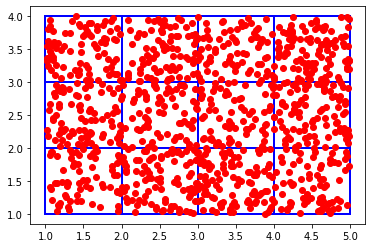

After:


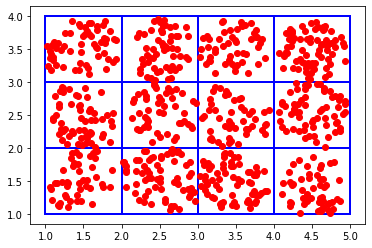

In [0]:
#Method1
def method1(h, percentage):
  numsOfNeighbours = np.zeros(l)
  for i in range(l):
    for j in range(l-1):
      if i > j and Y[i] == Y[j] or i <= j and Y[i] == Y[j+1]: 
        if allDistances[i][j] < h:
          numsOfNeighbours[i] += 1
  indices = []
  for ptsOfOneClass in classPoints.values():
    oneClassPtsNeighboursNums = list(map((lambda i: numsOfNeighbours[i]), ptsOfOneClass))
    newLen = -math.floor(len(ptsOfOneClass)*percentage)
    indices.extend(list(map((lambda i: ptsOfOneClass[i]), np.argpartition(oneClassPtsNeighboursNums, newLen)[newLen:])))
  newX = X[indices]
  newY = []
  for i in range(newX[:,0].size):
    newY.append(getClass(newX[i][0],newX[i][1]))
  return newX, newY

m1X, m1Y = method1(0.4, 0.7)

print("-----One example with h = 0.4 and percentage = 70%-----")
print("Before:")
plotClasses()
plt.plot(X[:,0], X[:,1], "ro")
plt.show()

print("After:")
plotClasses()
plt.plot(m1X[:,0], m1X[:,1], "ro")
plt.show()

One example with percentage = 70%
Before:


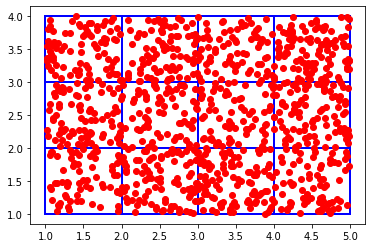

After:


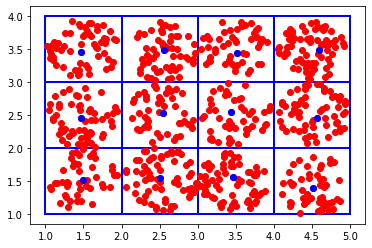

In [0]:
#Method2
def method2(percentage, returnCenters=False):
  sumsOfDistances = np.zeros(l)
  for i in range(l):
    for j in range(l-1):
      if i > j and Y[i] == Y[j] or i <= j and Y[i] == Y[j+1]: 
        sumsOfDistances[i] += allDistances[i][j]
  indices = []
  classCenters = []
  for ptsOfOneClass in classPoints.values():
    oneClassPtsSums = list(map((lambda i: sumsOfDistances[i]), ptsOfOneClass))
    newLen = math.floor(len(ptsOfOneClass)*percentage)
    indices.extend(list(map((lambda i: ptsOfOneClass[i]), np.argpartition(oneClassPtsSums, newLen)[:newLen])))
    classCenters.append(ptsOfOneClass[np.argmin(oneClassPtsSums)])
  newX = X[indices]
  newY = []
  for i in range(newX[:,0].size):
    newY.append(getClass(newX[i][0],newX[i][1]))
  if returnCenters:
    return newX, newY, classCenters
  else:
    return newX, newY

m2X, m2Y, m2centers = method2(0.7, True)

print("One example with percentage = 70%")
print("Before:")
plotClasses()
plt.plot(X[:,0], X[:,1], "ro")
plt.show()

print("After:")
plotClasses()
plt.plot(m2X[:,0], m2X[:,1], "ro")
plt.plot(X[m2centers][:,0], X[m2centers][:,1], "bo")
plt.show()

In [0]:
# defining parzen window method to test our new datasets
def parzenWindow(X, Y, distances, i, h, kernel):
  newY = Y.copy()
  expected = newY.pop(i)
  ySums = {}
  for cl in allClasses:
    ySums[cl] = 0
  for j in range(X[:,0].size-1):
    ySums[newY[j]] += kernel(distances[i][j]/h)
  res = max(ySums, key=ySums.get)
  return res == expected

kernel = lambda r: math.exp(-2 * r**2)
kernelName = "Gaussian"
parzenH = 0.3

def parzenWindowTest(X, Y):
  distances = getAllDistances(X)
  guesses = 0
  plotClasses()
  for i in range(X[:,0].size):
    res = parzenWindow(X, Y, distances, i, parzenH, kernel)
    if res:
      guesses += 1
      plt.plot(X[i][0], X[i][1], "go")
    else:
      plt.plot(X[i][0], X[i][1], "ro")
  accuracy = guesses / X[:,0].size
  print("Accuracy: {}/{} ({}%)".format(guesses, X[:,0].size, accuracy*100))
  plt.show()
  return accuracy

Testing new Datasets using Parzen Window with h = 0.3 and Gaussian kernel.

-----Method #1 Dataset-----
h = 0.5, percentage = 0.9
Accuracy: 863/894 (96.53243847874721%)


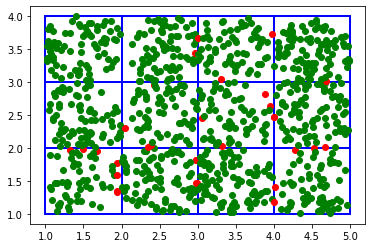

h = 0.45, percentage = 0.9
Accuracy: 858/894 (95.9731543624161%)


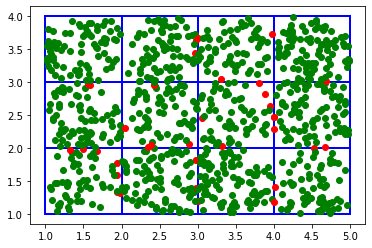

h = 0.4, percentage = 0.9
Accuracy: 857/894 (95.86129753914989%)


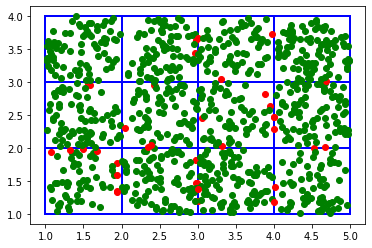

h = 0.35000000000000003, percentage = 0.9
Accuracy: 863/894 (96.53243847874721%)


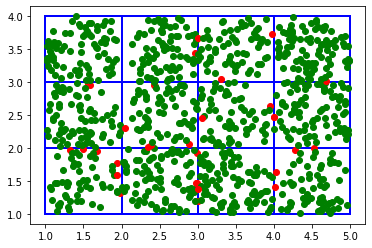

h = 0.30000000000000004, percentage = 0.9
Accuracy: 865/894 (96.75615212527964%)


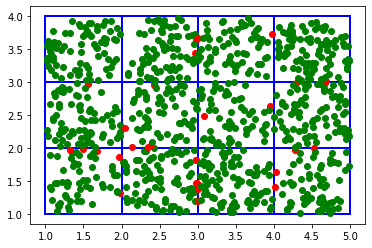

h = 0.25000000000000006, percentage = 0.9
Accuracy: 871/894 (97.42729306487695%)


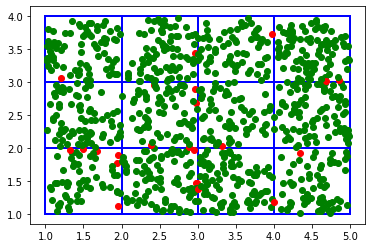

h = 0.20000000000000007, percentage = 0.9
Accuracy: 869/894 (97.20357941834452%)


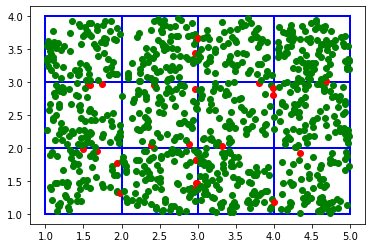

h = 0.15000000000000008, percentage = 0.9
Accuracy: 862/894 (96.42058165548099%)


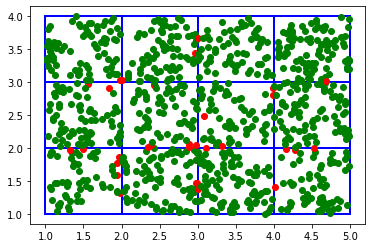

h = 0.10000000000000009, percentage = 0.9
Accuracy: 848/894 (94.85458612975391%)


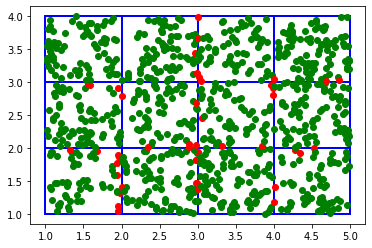

h = 0.5, percentage = 0.8
Accuracy: 785/796 (98.61809045226131%)


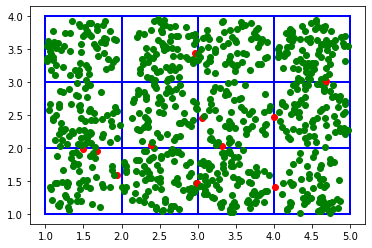

h = 0.45, percentage = 0.8
Accuracy: 780/796 (97.98994974874373%)


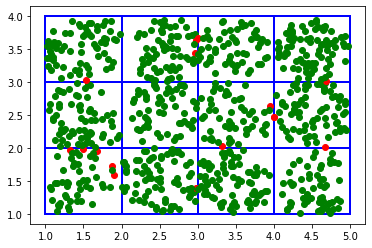

h = 0.4, percentage = 0.8
Accuracy: 781/796 (98.11557788944724%)


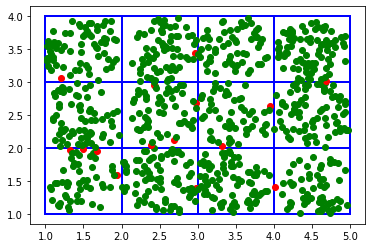

h = 0.35000000000000003, percentage = 0.8
Accuracy: 780/796 (97.98994974874373%)


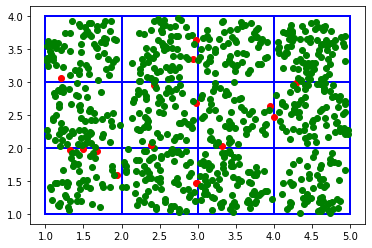

h = 0.30000000000000004, percentage = 0.8
Accuracy: 787/796 (98.86934673366834%)


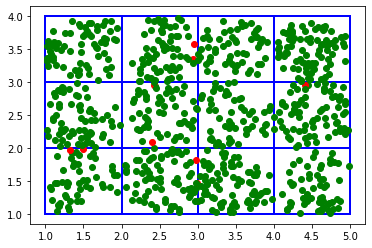

h = 0.25000000000000006, percentage = 0.8
Accuracy: 783/796 (98.36683417085426%)


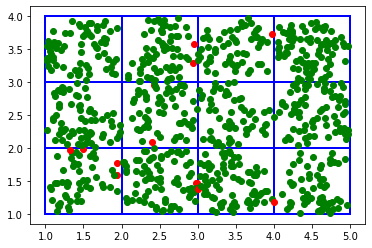

h = 0.20000000000000007, percentage = 0.8
Accuracy: 776/796 (97.48743718592965%)


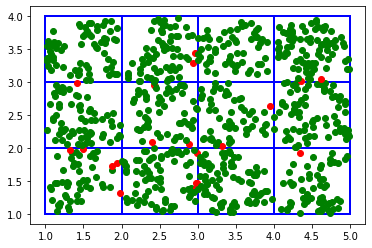

h = 0.15000000000000008, percentage = 0.8
Accuracy: 764/796 (95.97989949748744%)


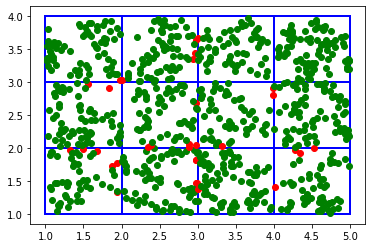

h = 0.10000000000000009, percentage = 0.8
Accuracy: 756/796 (94.9748743718593%)


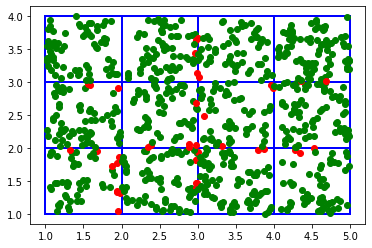

h = 0.5, percentage = 0.7000000000000001
Accuracy: 688/695 (98.99280575539568%)


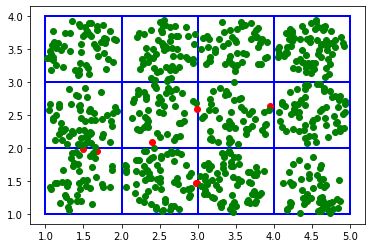

h = 0.45, percentage = 0.7000000000000001
Accuracy: 690/695 (99.28057553956835%)


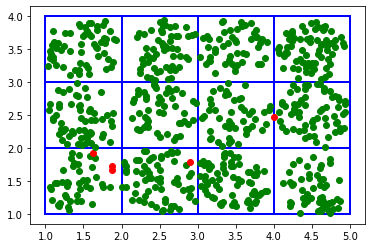

h = 0.4, percentage = 0.7000000000000001
Accuracy: 690/695 (99.28057553956835%)


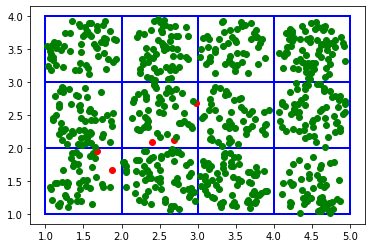

h = 0.35000000000000003, percentage = 0.7000000000000001
Accuracy: 687/695 (98.84892086330936%)


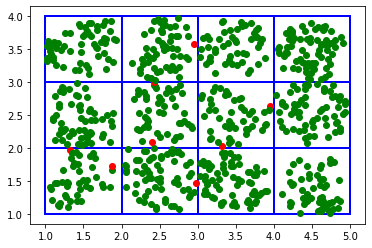

h = 0.30000000000000004, percentage = 0.7000000000000001
Accuracy: 689/695 (99.13669064748201%)


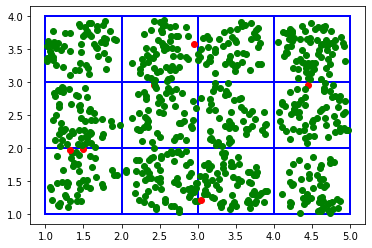

h = 0.25000000000000006, percentage = 0.7000000000000001
Accuracy: 688/695 (98.99280575539568%)


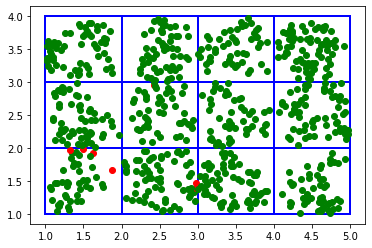

h = 0.20000000000000007, percentage = 0.7000000000000001
Accuracy: 685/695 (98.56115107913669%)


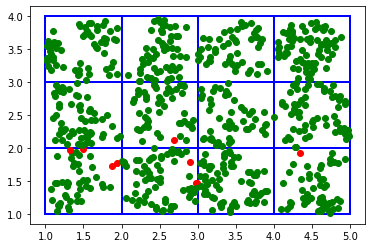

h = 0.15000000000000008, percentage = 0.7000000000000001
Accuracy: 674/695 (96.97841726618705%)


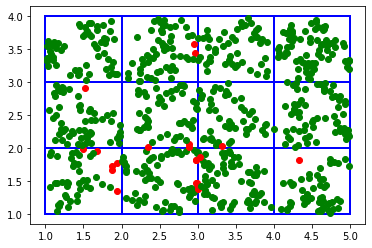

h = 0.10000000000000009, percentage = 0.7000000000000001
Accuracy: 662/695 (95.25179856115108%)


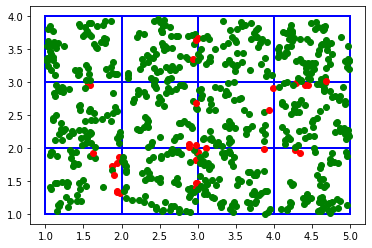

h = 0.5, percentage = 0.6000000000000001
Accuracy: 593/596 (99.49664429530202%)


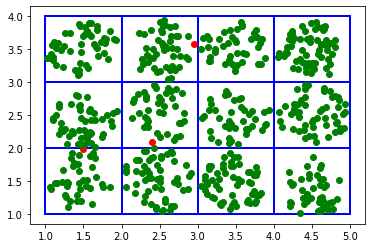

h = 0.45, percentage = 0.6000000000000001
Accuracy: 594/596 (99.66442953020133%)


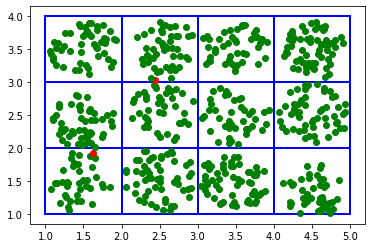

h = 0.4, percentage = 0.6000000000000001
Accuracy: 595/596 (99.83221476510067%)


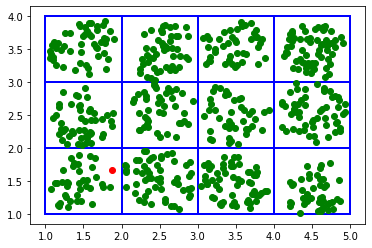

h = 0.35000000000000003, percentage = 0.6000000000000001
Accuracy: 595/596 (99.83221476510067%)


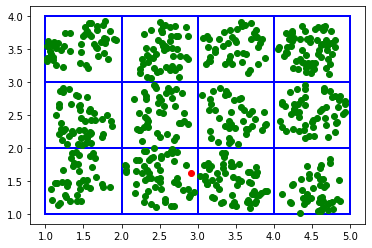

h = 0.30000000000000004, percentage = 0.6000000000000001
Accuracy: 592/596 (99.32885906040269%)


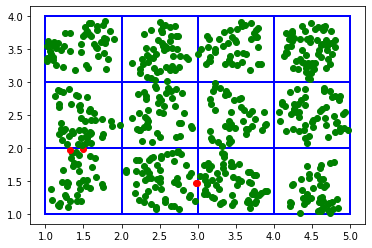

h = 0.25000000000000006, percentage = 0.6000000000000001
Accuracy: 591/596 (99.16107382550335%)


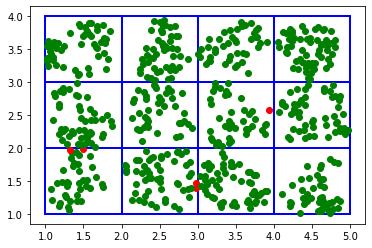

h = 0.20000000000000007, percentage = 0.6000000000000001
Accuracy: 590/596 (98.99328859060402%)


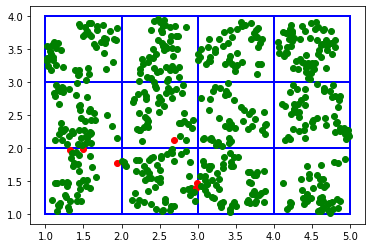

h = 0.15000000000000008, percentage = 0.6000000000000001
Accuracy: 583/596 (97.81879194630872%)


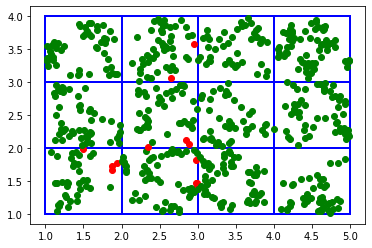

h = 0.10000000000000009, percentage = 0.6000000000000001
Accuracy: 573/596 (96.14093959731544%)


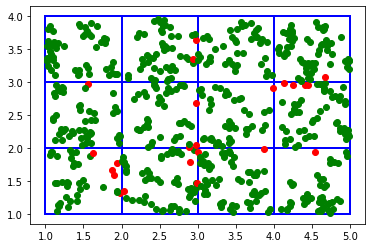

h = 0.5, percentage = 0.5000000000000001
Accuracy: 498/498 (100.0%)


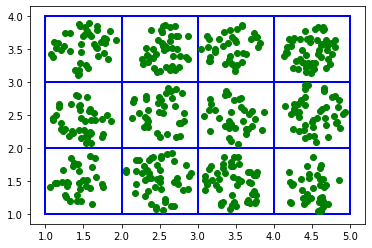

h = 0.45, percentage = 0.5000000000000001
Accuracy: 498/498 (100.0%)


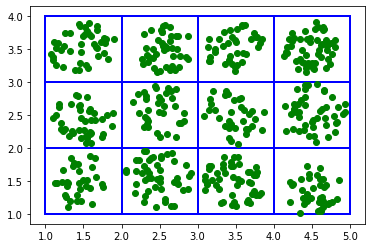

h = 0.4, percentage = 0.5000000000000001
Accuracy: 498/498 (100.0%)


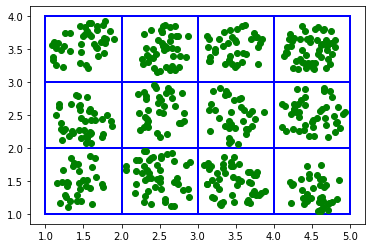

h = 0.35000000000000003, percentage = 0.5000000000000001
Accuracy: 497/498 (99.79919678714859%)


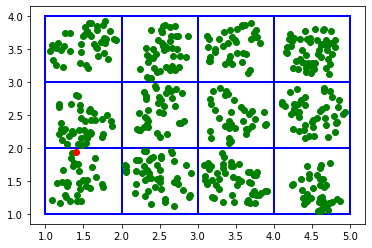

h = 0.30000000000000004, percentage = 0.5000000000000001
Accuracy: 497/498 (99.79919678714859%)


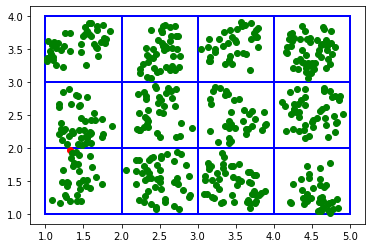

h = 0.25000000000000006, percentage = 0.5000000000000001
Accuracy: 494/498 (99.19678714859438%)


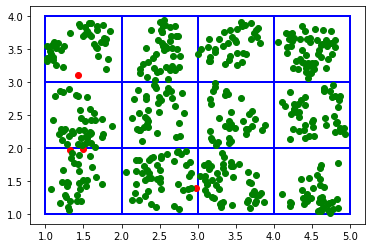

h = 0.20000000000000007, percentage = 0.5000000000000001
Accuracy: 496/498 (99.59839357429718%)


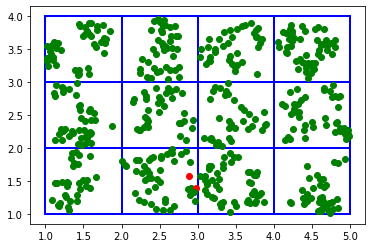

h = 0.15000000000000008, percentage = 0.5000000000000001
Accuracy: 490/498 (98.39357429718876%)


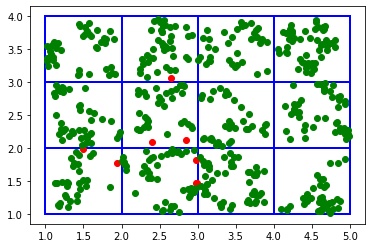

h = 0.10000000000000009, percentage = 0.5000000000000001
Accuracy: 478/498 (95.98393574297188%)


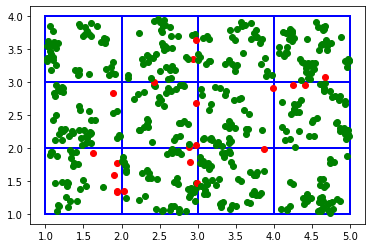

The best accuracy was reached with (h, percentage) = [(0.5, 0.5000000000000001), (0.45, 0.5000000000000001), (0.4, 0.5000000000000001)]: 100.0%


In [0]:
print("Testing new Datasets using Parzen Window with h = {} and {} kernel.\n".format(parzenH, kernelName))
print("-----Method #1 Dataset-----")
best = []
bestAccuracy = 0
for percentage in np.arange(0.9, 0.49, -0.1):
  for h in np.arange(0.5, 0.09, -0.05):
    print("h = {}, percentage = {}".format(h, percentage))
    m1X, m1Y = method1(h, percentage)
    accuracy = parzenWindowTest(m1X, m1Y)
    if accuracy > bestAccuracy:
      bestAccuracy = accuracy
      best = [(h, percentage)]
    elif accuracy == bestAccuracy:
      best.append((h, percentage))
m1X, m1Y = method1(best[0][0], best[0][1])

print("The best accuracy was reached with (h, percentage) = {}: {}%".format(best[0] if len(best) == 1 else best, bestAccuracy*100))

-----Method #2 Dataset-----
percentage = 90.0%
Accuracy: 856/894 (95.74944071588367%)


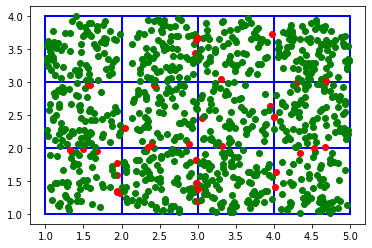

percentage = 85.0%
Accuracy: 822/843 (97.50889679715303%)


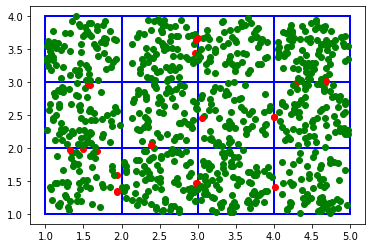

percentage = 80.0%
Accuracy: 779/794 (98.11083123425692%)


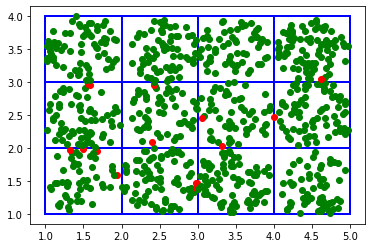

percentage = 74.99999999999999%
Accuracy: 734/742 (98.92183288409704%)


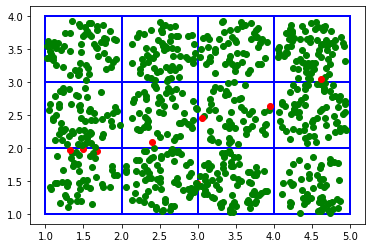

percentage = 69.99999999999999%
Accuracy: 690/694 (99.42363112391931%)


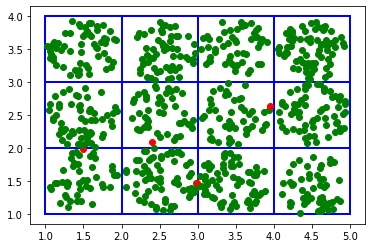

percentage = 64.99999999999999%
Accuracy: 643/644 (99.84472049689441%)


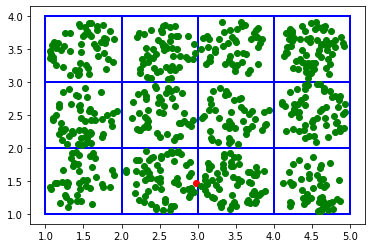

percentage = 59.99999999999998%
Accuracy: 593/593 (100.0%)


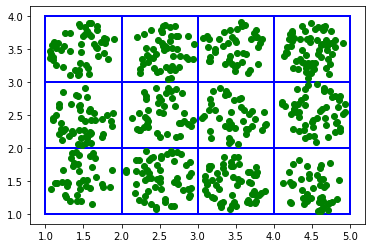

percentage = 54.99999999999997%
Accuracy: 544/544 (100.0%)


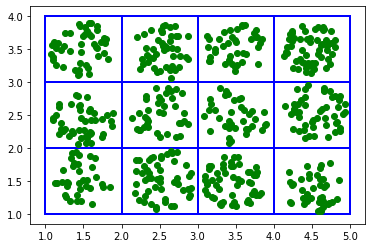

percentage = 49.999999999999964%
Accuracy: 490/490 (100.0%)


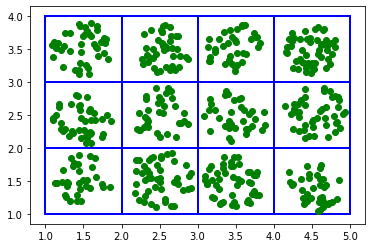

The best accuracy was reached with percentage = [0.5999999999999998, 0.5499999999999997, 0.49999999999999967]: 100.0%


In [0]:
print("-----Method #2 Dataset-----")
best = []
bestAccuracy = 0
for percentage in np.arange(0.9, 0.49, -0.05):
  print("percentage = {}%".format(percentage*100))
  m2X, m2Y = method2(percentage)
  accuracy = parzenWindowTest(m2X, m2Y)
  if accuracy > bestAccuracy:
      bestAccuracy = accuracy
      best = [percentage]
  elif accuracy == bestAccuracy:
    best.append(percentage)
m2X, m2Y = method2(best[0])

print("The best accuracy was reached with percentage = {}: {}%".format(best[0] if len(best) == 1 else best, bestAccuracy*100))

In [0]:
# defining parzen window for one additional point
def parzenWindowAdditional(x, X, Y, h, kernel):
  expected = getClass(x[0], x[1])
  ySums = {}
  for cl in allClasses:
    ySums[cl] = 0
  for i in range(X[:,0].size-1):
    ySums[Y[i]] += kernel(distanceBetween(x, X[i])/h)
  res = max(ySums, key=ySums.get)
  return res == expected

def parzenWindowTestAdditional(X_test, X, Y):
  guesses = 0
  plotClasses()
  for x in X_test:
    res = parzenWindowAdditional(x, X, Y, parzenH, kernel)
    if res:
      guesses += 1
      plt.plot(x[0], x[1], "go")
    else:
      plt.plot(x[0], x[1], "ro")
  accuracy = guesses / X_test[:,0].size
  print("Accuracy: {}/{} ({}%)".format(guesses, X_test[:,0].size, accuracy*100))
  plt.show()
  return accuracy

Testing new Datasets on new values using Parzen Window with h = 0.3 and Gaussian kernel.

-----Method #1 Dataset-----
Accuracy: 944/1000 (94.39999999999999%)


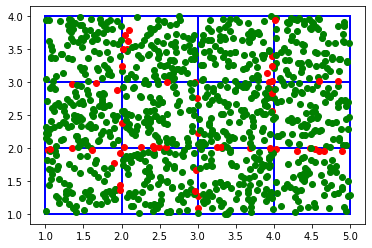

-----Method #2 Dataset-----
Accuracy: 937/1000 (93.7%)


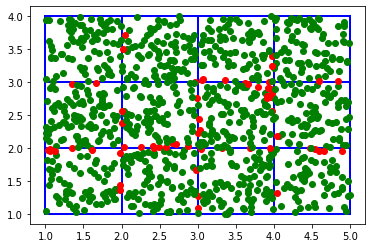

0.937

In [0]:
X_test = getDataset()

print("Testing new Datasets on new values using Parzen Window with h = {} and {} kernel.\n".format(parzenH, kernelName))
print("-----Method #1 Dataset-----")
parzenWindowTestAdditional(X_test, m1X, m1Y)
print("-----Method #2 Dataset-----")
parzenWindowTestAdditional(X_test, m2X, m2Y)

Testing new Datasets using Parzen Window with h = 0.3 and Gaussian kernel.

-----Method #1 Dataset-----
h = 0.5, percentage = 0.9
Accuracy: 953/1000 (95.3%)


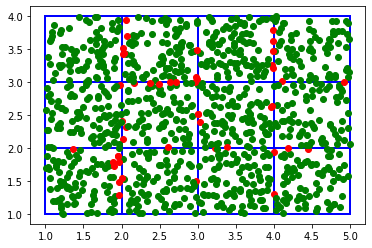

h = 0.45, percentage = 0.9
Accuracy: 955/1000 (95.5%)


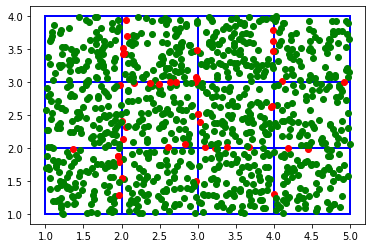

h = 0.4, percentage = 0.9
Accuracy: 956/1000 (95.6%)


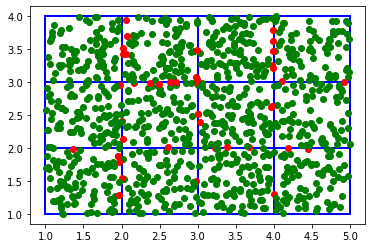

h = 0.35000000000000003, percentage = 0.9
Accuracy: 954/1000 (95.39999999999999%)


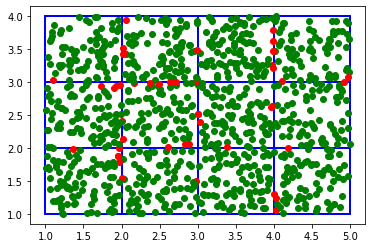

h = 0.30000000000000004, percentage = 0.9
Accuracy: 946/1000 (94.6%)


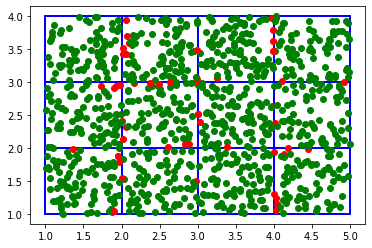

h = 0.25000000000000006, percentage = 0.9
Accuracy: 951/1000 (95.1%)


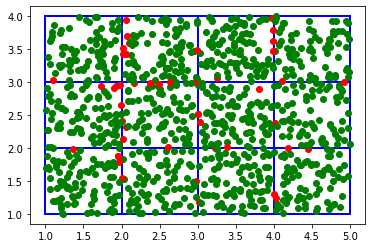

h = 0.20000000000000007, percentage = 0.9
Accuracy: 937/1000 (93.7%)


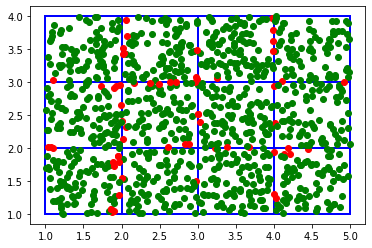

h = 0.15000000000000008, percentage = 0.9
Accuracy: 941/1000 (94.1%)


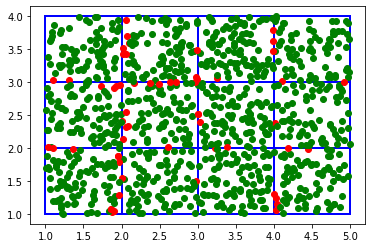

h = 0.10000000000000009, percentage = 0.9
Accuracy: 948/1000 (94.8%)


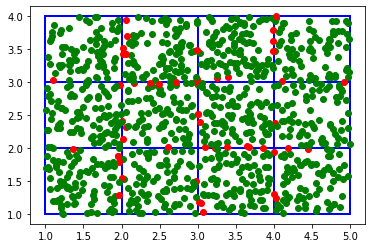

h = 0.5, percentage = 0.8
Accuracy: 949/1000 (94.89999999999999%)


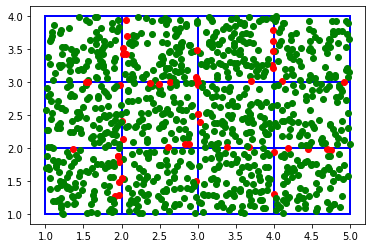

h = 0.45, percentage = 0.8
Accuracy: 938/1000 (93.8%)


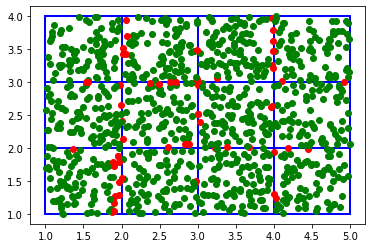

h = 0.4, percentage = 0.8
Accuracy: 940/1000 (94.0%)


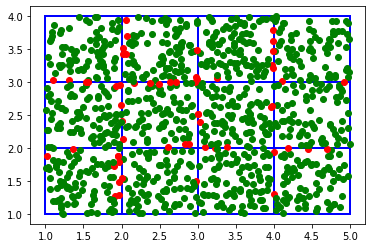

h = 0.35000000000000003, percentage = 0.8
Accuracy: 946/1000 (94.6%)


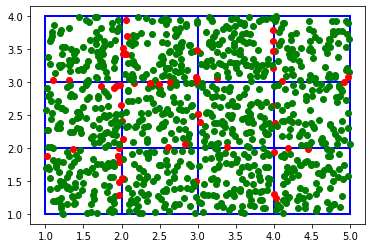

h = 0.30000000000000004, percentage = 0.8
Accuracy: 947/1000 (94.69999999999999%)


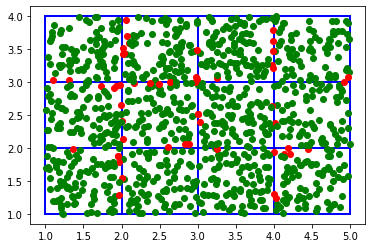

h = 0.25000000000000006, percentage = 0.8
Accuracy: 937/1000 (93.7%)


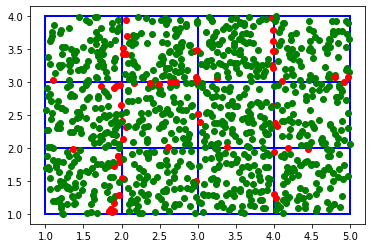

h = 0.20000000000000007, percentage = 0.8
Accuracy: 923/1000 (92.30000000000001%)


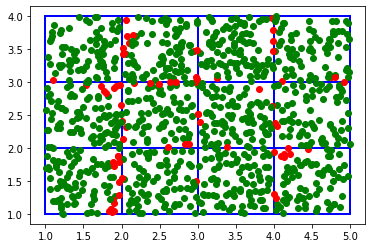

h = 0.15000000000000008, percentage = 0.8
Accuracy: 934/1000 (93.4%)


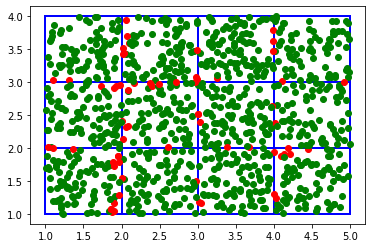

h = 0.10000000000000009, percentage = 0.8
Accuracy: 947/1000 (94.69999999999999%)


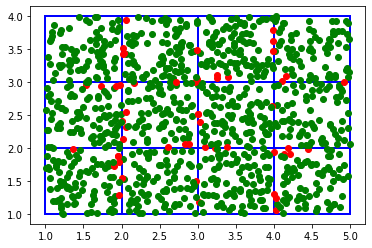

h = 0.5, percentage = 0.7000000000000001
Accuracy: 953/1000 (95.3%)


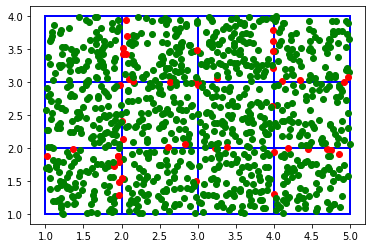

h = 0.45, percentage = 0.7000000000000001
Accuracy: 950/1000 (95.0%)


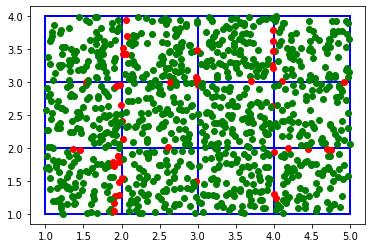

h = 0.4, percentage = 0.7000000000000001
Accuracy: 946/1000 (94.6%)


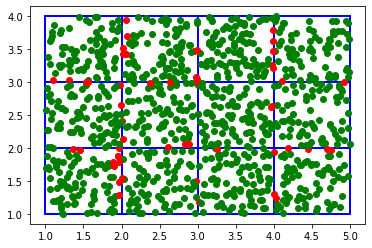

h = 0.35000000000000003, percentage = 0.7000000000000001
Accuracy: 947/1000 (94.69999999999999%)


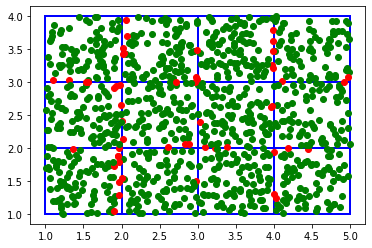

h = 0.30000000000000004, percentage = 0.7000000000000001
Accuracy: 947/1000 (94.69999999999999%)


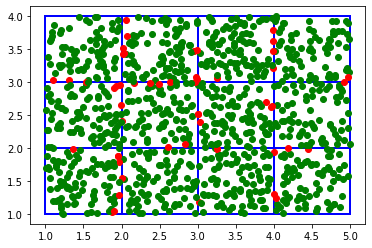

h = 0.25000000000000006, percentage = 0.7000000000000001
Accuracy: 929/1000 (92.9%)


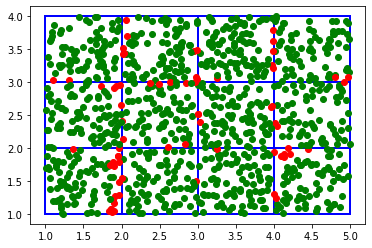

h = 0.20000000000000007, percentage = 0.7000000000000001
Accuracy: 913/1000 (91.3%)


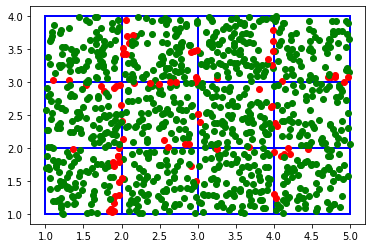

h = 0.15000000000000008, percentage = 0.7000000000000001
Accuracy: 924/1000 (92.4%)


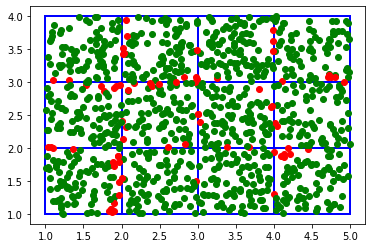

h = 0.10000000000000009, percentage = 0.7000000000000001
Accuracy: 945/1000 (94.5%)


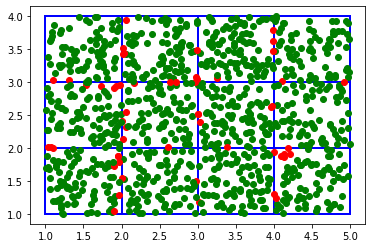

h = 0.5, percentage = 0.6000000000000001
Accuracy: 943/1000 (94.3%)


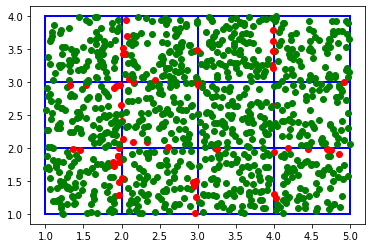

h = 0.45, percentage = 0.6000000000000001
Accuracy: 948/1000 (94.8%)


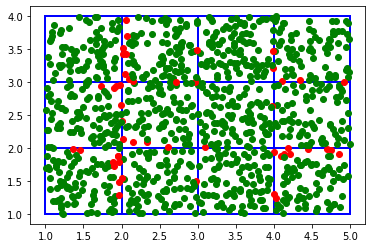

h = 0.4, percentage = 0.6000000000000001
Accuracy: 952/1000 (95.19999999999999%)


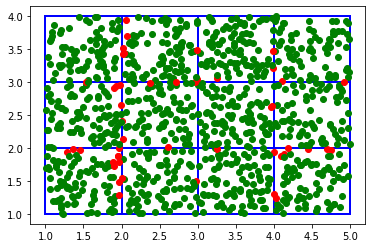

h = 0.35000000000000003, percentage = 0.6000000000000001
Accuracy: 944/1000 (94.39999999999999%)


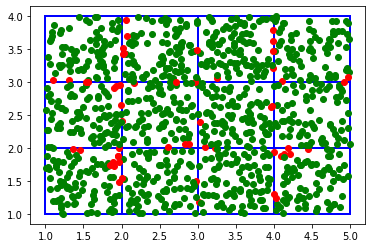

h = 0.30000000000000004, percentage = 0.6000000000000001
Accuracy: 936/1000 (93.60000000000001%)


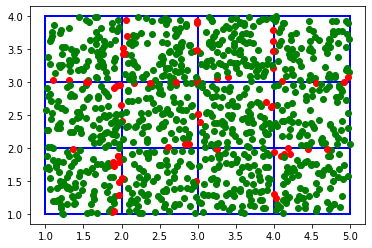

h = 0.25000000000000006, percentage = 0.6000000000000001
Accuracy: 927/1000 (92.7%)


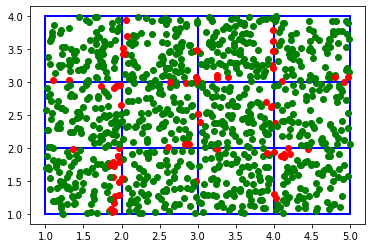

h = 0.20000000000000007, percentage = 0.6000000000000001
Accuracy: 910/1000 (91.0%)


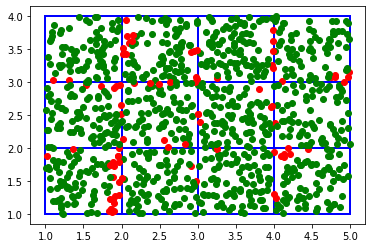

h = 0.15000000000000008, percentage = 0.6000000000000001
Accuracy: 915/1000 (91.5%)


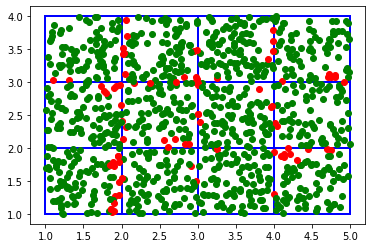

h = 0.10000000000000009, percentage = 0.6000000000000001
Accuracy: 941/1000 (94.1%)


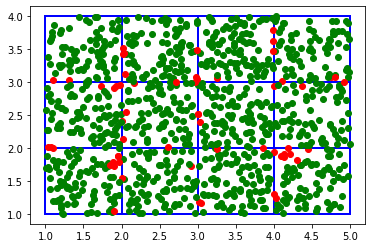

h = 0.5, percentage = 0.5000000000000001
Accuracy: 948/1000 (94.8%)


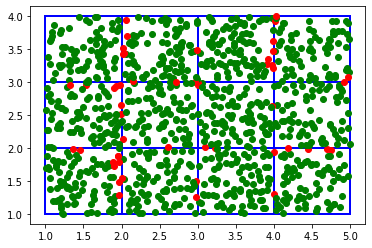

h = 0.45, percentage = 0.5000000000000001
Accuracy: 942/1000 (94.19999999999999%)


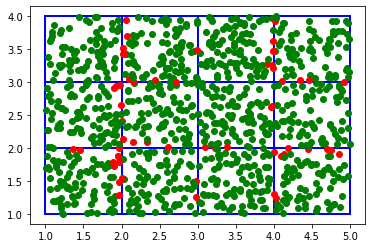

h = 0.4, percentage = 0.5000000000000001
Accuracy: 942/1000 (94.19999999999999%)


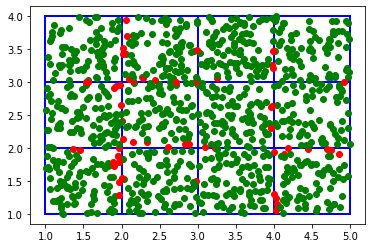

h = 0.35000000000000003, percentage = 0.5000000000000001
Accuracy: 938/1000 (93.8%)


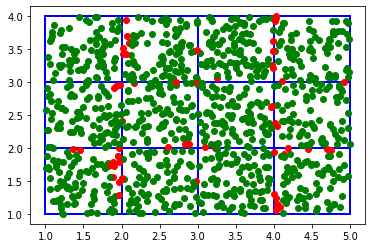

h = 0.30000000000000004, percentage = 0.5000000000000001
Accuracy: 937/1000 (93.7%)


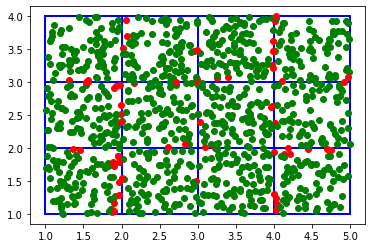

h = 0.25000000000000006, percentage = 0.5000000000000001
Accuracy: 925/1000 (92.5%)


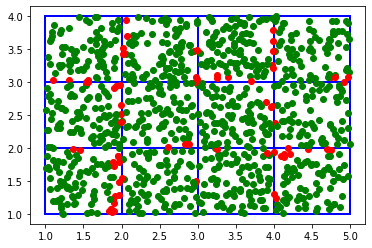

h = 0.20000000000000007, percentage = 0.5000000000000001
Accuracy: 909/1000 (90.9%)


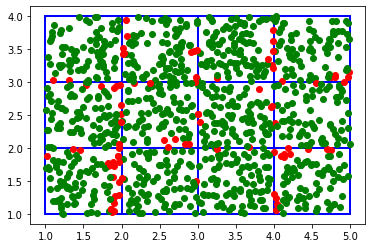

h = 0.15000000000000008, percentage = 0.5000000000000001
Accuracy: 909/1000 (90.9%)


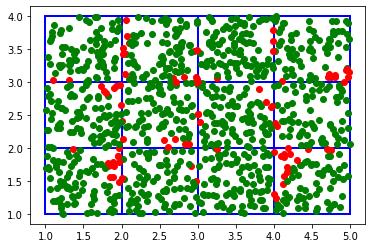

h = 0.10000000000000009, percentage = 0.5000000000000001
Accuracy: 927/1000 (92.7%)


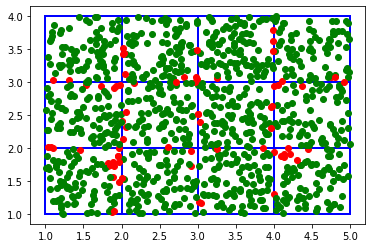

The best accuracy was reached with (h, percentage) = (0.4, 0.9): 95.6%


In [0]:
X_test = getDataset()

print("Testing new Datasets using Parzen Window with h = {} and {} kernel.\n".format(parzenH, kernelName))
print("-----Method #1 Dataset-----")
best = []
bestAccuracy = 0
for percentage in np.arange(0.9, 0.49, -0.1):
  for h in np.arange(0.5, 0.09, -0.05):
    print("h = {}, percentage = {}".format(h, percentage))
    m1X, m1Y = method1(h, percentage)
    accuracy = parzenWindowTestAdditional(X_test, m1X, m1Y)
    if accuracy > bestAccuracy:
      bestAccuracy = accuracy
      best = [(h, percentage)]
    elif accuracy == bestAccuracy:
      best.append((h, percentage))
m1X, m1Y = method1(best[0][0], best[0][1])

print("The best accuracy was reached with (h, percentage) = {}: {}%".format(best[0] if len(best) == 1 else best, bestAccuracy*100))

-----Method #2 Dataset-----
percentage = 90.0%
Accuracy: 954/1000 (95.39999999999999%)


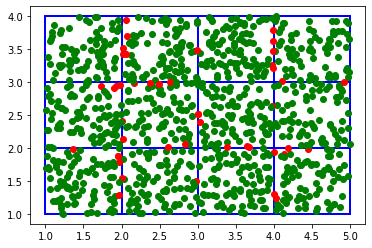

percentage = 85.0%
Accuracy: 958/1000 (95.8%)


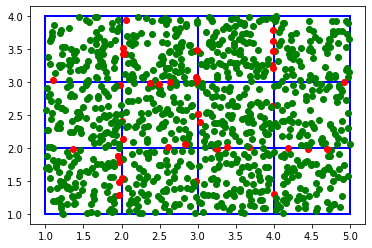

percentage = 80.0%
Accuracy: 949/1000 (94.89999999999999%)


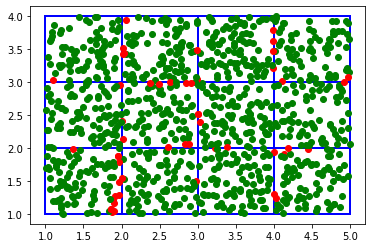

percentage = 74.99999999999999%
Accuracy: 957/1000 (95.7%)


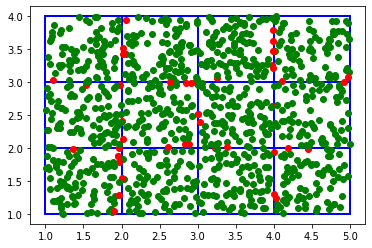

percentage = 69.99999999999999%
Accuracy: 964/1000 (96.39999999999999%)


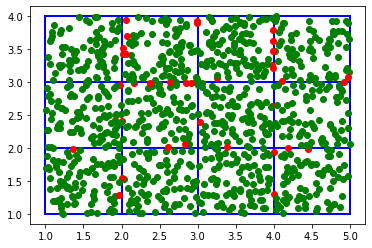

percentage = 64.99999999999999%
Accuracy: 963/1000 (96.3%)


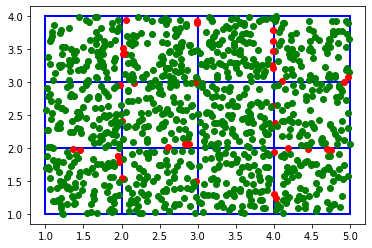

percentage = 59.99999999999998%
Accuracy: 966/1000 (96.6%)


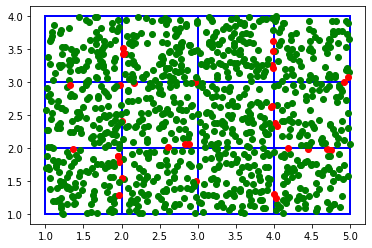

percentage = 54.99999999999997%
Accuracy: 961/1000 (96.1%)


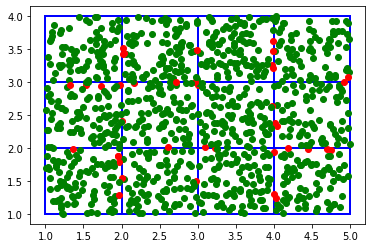

percentage = 49.999999999999964%
Accuracy: 959/1000 (95.89999999999999%)


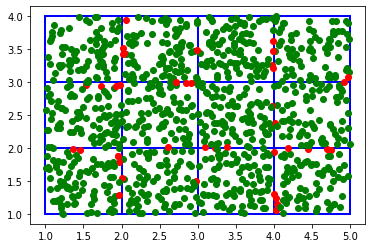

The best accuracy was reached with percentage = 0.5999999999999998: 96.6%


In [0]:
print("-----Method #2 Dataset-----")
best = []
bestAccuracy = 0
for percentage in np.arange(0.9, 0.49, -0.05):
  print("percentage = {}%".format(percentage*100))
  m2X, m2Y = method2(percentage)
  accuracy = parzenWindowTestAdditional(X_test, m2X, m2Y)
  if accuracy > bestAccuracy:
      bestAccuracy = accuracy
      best = [percentage]
  elif accuracy == bestAccuracy:
    best.append(percentage)
m2X, m2Y = method2(best[0])

print("The best accuracy was reached with percentage = {}: {}%".format(best[0] if len(best) == 1 else best, bestAccuracy*100))